In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
# 코랩을 사용하지 않으면 이 셀의 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=6)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 653 (delta 47), reused 15 (delta 8), pack-reused 569
Receiving objects: 100% (653/653), 62.41 MiB | 21.87 MiB/s, done.
Resolving deltas: 100% (335/335), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.42.4
Using datasets v2.20.0
Using accelerate v0.32.1
Using sentencepiece v0.1.99
Using sacrebleu v2.4.2
Using rouge_score
Using nltk v3.8.1
Using py7zr v0.21.1


In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer

In [2]:
from datasets import load_dataset

# "cnn_dailymail" 데이터셋 다운로드 에러가 발생할 경우 대신 "ccdv/cnn_dailymail"을 사용하세요.
dataset = load_dataset("ccdv/cnn_dailymail", version="3.0.0")
print(f"특성: {dataset['train'].column_names}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


특성: ['article', 'highlights', 'id']


In [3]:
print(f"특성: {dataset['train'].column_names}")
print(f"샘플 수: {len(dataset['train'])}")

특성: ['article', 'highlights', 'id']
샘플 수: 287113


In [4]:
sample = dataset['train'][1]
print(f"""기사 (500개 문자 발췌, 총 길이: {len(sample["article"])}):""")
print(sample["article"][:500])
print(f"""요약 길이: {len(sample["highlights"])}""")
print(sample["highlights"])

기사 (500개 문자 발췌, 총 길이: 3192):
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has n
요약 길이: 180
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .


In [5]:
sample_text = dataset["train"][1]["article"][:2000]
summaries = {}

In [6]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

string = "The U.S are a country. The U.N. is an organization."
sent_tokenize(string)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['The U.S are a country.', 'The U.N. is an organization.']

In [7]:
def three_sentence_summary(text):
  return "\n".join(sent_tokenize(text)[:3])

summaries["baseline"] = three_sentence_summary(sample_text)
summaries

{'baseline': "(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.\nThe fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.\nThe U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover."}

In [8]:
from transformers import pipeline, set_seed

set_seed(42)
pipe = pipeline("text-generation", model="gpt2-xl")
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [9]:
summaries["gpt2"]

"Bolt finished in style by winning the final sprint event in Moscow.\nThere is still a few sprint events to go before Friday's final but so far this final gold should stand as a world record."

In [10]:
pipe = pipeline("summarization", model="t5-small")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [11]:
summaries["t5"]

"usain Bolt wins men's 4x100m relay gold in Moscow .\nthe fastest man in the world wins in 37.36 seconds .\ncanada takes bronze after being disqualified for a faulty handover ."

In [12]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [13]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [14]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])

for model_name in summaries:
  print(f"\n{model_name.upper()}")
  print(summaries[model_name])
  print("")

GROUND TRUTH
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .

BASELINE
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.
The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.
The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover.


GPT2
Bolt finished in style by winning the final sprint event in Moscow.
There is still a few sprint events to go before Friday's final but so far this final gold should stand as a world record.


T5
usain Bolt wins men's 4x100m relay gold in Moscow .
the fastest man in the world wins in 37.36 seconds .
canada takes br

In [18]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.3 MB/s eta 0:00:00


In [15]:
import evaluate

bleu_metric = evaluate.load("sacrebleu")

In [16]:
bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"]
)
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [17]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"]
)
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


In [18]:
rouge_metric = evaluate.load("rouge")

In [19]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
  rouge_metric.add(prediction=summaries[model_name], reference=reference)
  score = rouge_metric.compute()
  rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
  records.append(rouge_dict)

pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.303571,0.090909,0.214286,0.232143
gpt2,0.212121,0.000000,0.121212,0.212121
t5,0.366667,0.137931,0.266667,0.333333
bart,0.582278,0.207792,0.455696,0.506329
pegasus,0.866667,0.655172,0.800000,0.833333


# CNN/DailyMail Dataset에서 PEGASUS 평가하기

In [20]:
def evaluate_summaries_baseline(dataset, metric,
                                column_text="article",
                                column_summary="highlights"):
  summaries = [three_sentence_summary(text) for text in dataset[column_text]]
  metric.add_batch(predictions=summaries, references=dataset[column_summary])
  score = metric.compute()
  return score

In [21]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(10))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["Value"]).T

,rouge1,rouge2,rougeL,rougeLsum
Value,0.389738,0.159796,0.238158,0.364452


In [22]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
  for i in range(0, len(list_of_elements), batch_size):
    yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
  article_batches = list(chunks(dataset[column_text], batch_size))
  target_batches = list(chunks(dataset[column_summary], batch_size))

  for article_batch, target_batch in tqdm(
      zip(article_batches, target_batches), total=len(article_batches)):
    inputs = tokenizer(article_batch, max_length=1024, truncation=True,
                       padding="max_length", return_tensors="pt")
    summaries = model.generate(input_ids=inputs["input_ids"].to(device),
        attention_mask=inputs["attention_mask"].to(device),
        length_penalty=0.8, num_beams=8, max_length=128)
    decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                          clean_up_tokenization_spaces=True) for s in summaries]
    decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
    target_batch = [[t] for t in target_batch]
    metric.add_batch(predictions=decoded_summaries, references=target_batch)
  score = metric.compute()
  return score

In [23]:
torch.cuda.empty_cache()

In [25]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

test_sampled = dataset["test"].shuffle(seed=42).select(range(40))
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(
    test_sampled, rouge_metric, model, tokenizer, batch_size=8
)
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 5/5 [01:00<00:00, 12.07s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.423682,0.195923,0.299239,0.362958


In [26]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]
print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [27]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [28]:
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, model, tokenizer,
    column_text="dialogue", column_summary="summary",
    batch_size=4
)
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 205/205 [17:56<00:00,  5.25s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296091,0.087493,0.229237,0.229642


Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


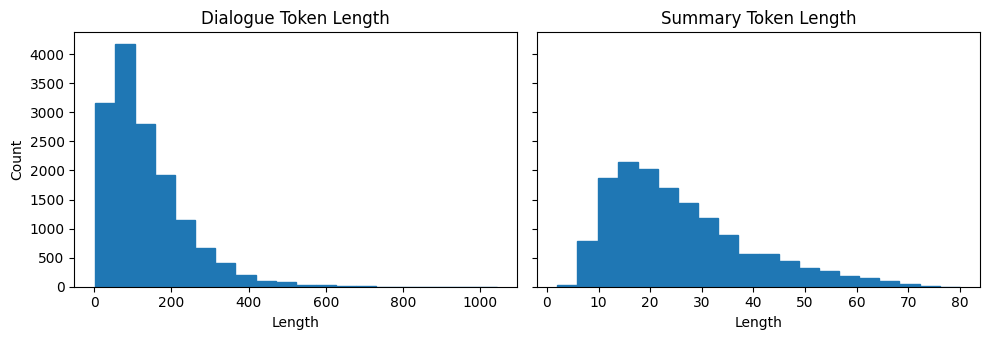

In [29]:
import matplotlib.pyplot as plt

d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [30]:
def convert_examples_to_features(example_batch):
  input_encodings = tokenizer(example_batch["dialogue"],
                              max_length=1024, truncation=True)
  targegt_encodings = tokenizer(example_batch["summary"],
                               max_length=128, truncation=True)

  return {
      "input_ids": input_encodings["input_ids"],
      "attention_mask": input_encodings["attention_mask"],
      "labels": targegt_encodings["input_ids"]
  }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
                                  batched=True)
columns = ["input_ids", "attention_mask", "labels"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [31]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [32]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="pegasus-samsum", num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy="steps", eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16, push_to_hub=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [37]:
trainer = Trainer(model=model, args=training_args,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"],
                  data_collator=seq2seq_data_collator,
                  tokenizer=tokenizer)

In [38]:
trainer.train()
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer, batch_size=2,
    column_text="dialogue", column_summary="summary"
)
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

/usr/local/lib/python3.10/dist-packages/transformers/data/data_collator.py:656: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Step,Training Loss,Validation Loss
500,1.659900,1.483296


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}
100%|██████████| 410/410 [12:35<00:00,  1.84s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.426953,0.202533,0.340666,0.340838


In [39]:
trainer.push_to_hub("Training complete!")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}


CommitInfo(commit_url='https://huggingface.co/blue2959/pegasus-samsum/commit/2278a3afc9bc783a976dabb024085d04c656632e', commit_message='Training complete!', commit_description='', oid='2278a3afc9bc783a976dabb024085d04c656632e', pr_url=None, pr_revision=None, pr_num=None)

# 대화요약 생성하기

In [40]:
gen_kwargs = {"length_penalty": .8, "num_beams": 8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="blue2959/pegasus-samsum")



config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.3k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.60M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


In [58]:
sample_text
"""
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye
"""

"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"

In [59]:
reference
"""
Hannah needs Betty's number but Amanda doesn't have it.
She needs to contact Larry.
"""

"Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry."

In [60]:
pipe(sample_text, **gen_kwargs)[0]["summary_text"]

##
"""
Amanda can't find Betty's number.
Larry called Betty last time they were at the park together.
Hannah wants Amanda to text Larry. Amanda will text Larry.
"""

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


"Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry. Amanda will text Larry."

## Test2

In [57]:
custom_dialogue = """\
Thom: Hi_guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great libarary by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea!, how hard can it be?
Thom: I am in!
Lewis: Awesome, let's do it together!
"""

Your max_length is set to 128, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


"Thom, Lewis, Leandro and Lewis are going to write a book about transformers. They are going to do it together, but it's not easy."

In [55]:
reference
"""
Hannah needs Betty's number but Amanda doesn't have it.
She needs to contact Larry.
"""

"Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry."

In [56]:
pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"]

"""
Thom, Lewis, Leandro and Lewis are going to write a book about transformers.
They are going to do it together, but it's not easy.
"""

Your max_length is set to 128, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


"Thom, Lewis, Leandro and Lewis are going to write a book about transformers. They are going to do it together, but it's not easy."